In [1]:
import numpy as np
import pygl, sys, time 
import scipy as sp
from scipy.io import savemat, loadmat
from tqdm import trange

$$
\dot{\phi}  +\boldsymbol{\nabla}\cdot\boldsymbol{J} =0. 
$$

$$
\boldsymbol{J} =M\left(-\boldsymbol{\nabla}\mu+\zeta(\nabla^{2}\phi)\boldsymbol{\nabla}\phi\right)+\sqrt{2DM}\boldsymbol{\Lambda}, 
$$

$$
\mu  =\mu^{E}+\mu^{\lambda},\quad\mu^{E}=\frac{\delta\mathcal{F}}{\delta\phi},\quad\mu^{\lambda}=\lambda|\boldsymbol{\nabla}\phi|^{2}.
$$

In [2]:
class activeModels():
    '''Class to solve a active model B+'''
    def __init__(self, Nt, dt, dd, rhs):
        self.Nt = Nt
        self.dt = dt
        self.dd = dd
        
        self.rhs = rhs 
        self.XX  = np.zeros((int(self.dd+1), Ng*Ng)) 
        
    def integrate(self, u):
        '''  simulates the equation and plots it at different instants '''
        ii=0;         t1 = time.perf_counter()
        
        for i in trange(self.Nt):           
            u = u + self.dt*self.rhs(u)
            if i%(int(self.Nt/self.dd))==0:  
                self.XX[ii,:] = u.flatten()
                ii += 1 

In [3]:
# now set-up the simulation 
Ng, zeta   = 64, 2 

a, b, k  = -0.25, 0.25, 1
phi0, lmda_a = 0.6 , 1.2

dim, h  = 2, 1 
Nt, dt, dd = int(6e6), .003, 2000

grid = {"dim":dim, "Nx":Ng, "Ny":Ng}
ff = pygl.utils.FiniteDifference(grid)

#Teff=0.1;  nfac=np.sqrt(2*Teff/(h*h*dt))
nfac=1.6

In [4]:
def rhs(u):
    '''
    returns the right hand side of active model B+
    '''    
    u_x=ff.diffx(u);  u_y=ff.diffy(u);  upp=ff.laplacian(u);  
    gp2 = (u_x*u_x + u_y*u_y)

    chemPot = -.25*u + .25*u*u*u - upp + lmda_a*gp2

    Lmdax = nfac*np.random.randn(Ng,Ng)
    Lmday = nfac*np.random.randn(Ng,Ng)
    
    jx = -ff.diffx1(chemPot) + Lmdax + zeta*upp*u_x 
    jy = -ff.diffy1(chemPot) + Lmday + zeta*upp*u_y 
    du = -ff.diffx1(jx) - ff.diffy1(jy)
    return du  

In [5]:
am = activeModels(Nt, dt, dd, rhs)
u = 0.0*(1-2*np.random.random((Ng, Ng)))
r1, xb1, yb1 = Ng/8, Ng/4, Ng/2
r2, xb2, yb2 = Ng/5, 3*Ng/4, Ng/2
u = pygl.utils.twoBubbles(u, r1, xb1, yb1, r2, xb2, yb2)

## Run the simulation and save data


In [6]:
t1 = time.perf_counter()

am.integrate(u)

100%|███████████████████████████████| 6000000/6000000 [23:54<00:00, 4181.36it/s]


In [7]:
## save data
savemat('N%s_z%2.2f_l%2.2f_4.4f_u%2.2f_nf%4.4f_bubbp.mat'%(Ng, zeta, lmda_a,  phi0, nfac), 
        {'X':am.XX, 'a':a, 'b':b, 'k':k, 'Ng':Ng, 'Nt':am.Nt, 'dt':dt, 'nfac':nfac, 'Tsim':time.perf_counter()-t1})

## Plot snapshots

In [8]:
import matplotlib.pyplot as plt

In [9]:
def configPlot(U, fig, n_, i):
    import matplotlib.pyplot as plt
    sp =  fig.add_subplot(2, 4, n_ )   

    im=plt.pcolor(U, cmap=plt.cm.RdBu_r);  plt.clim(-1.1, 1.1);
    cbar = plt.colorbar(im,fraction=0.04, pad=0.05, orientation="horizontal", 
                        ticks=[-1, 0, 1])

    plt.axis('off'); plt.title('T = %1.2E'%(i))

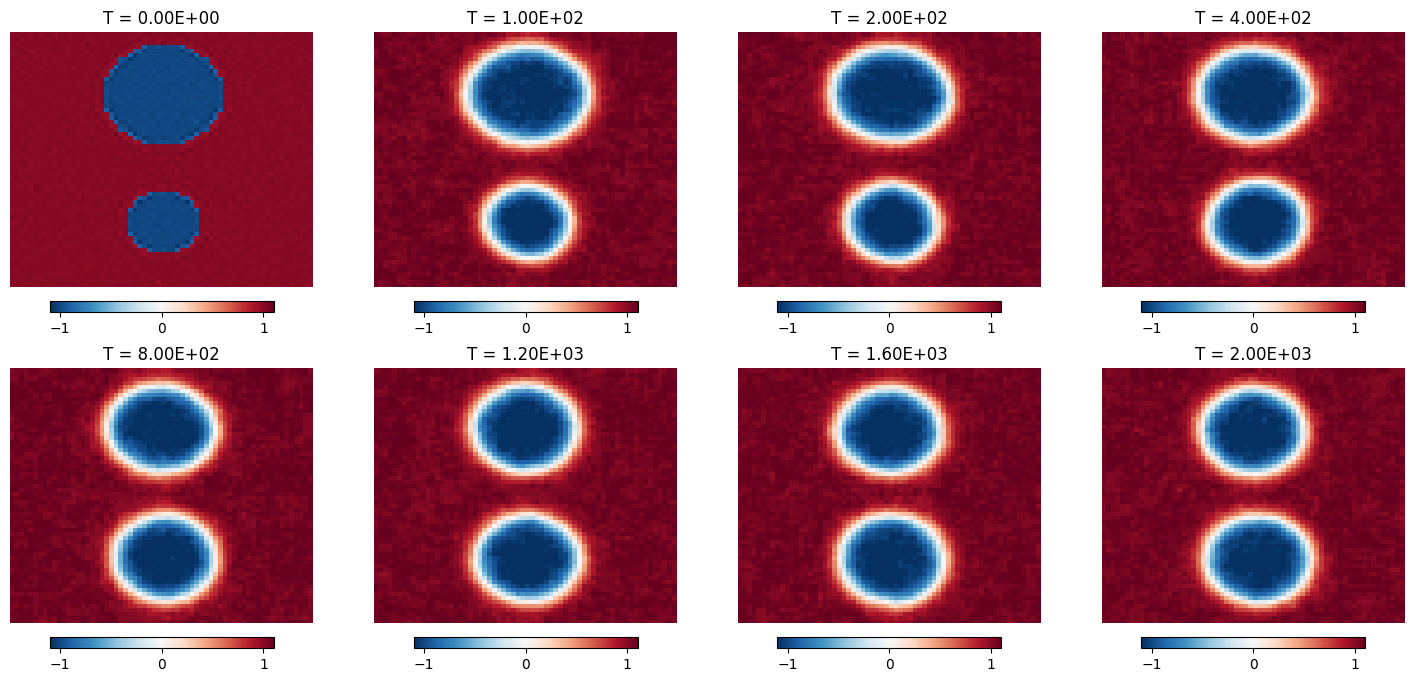

In [10]:
fig = plt.figure(num=None, figsize=(18, 8), dpi=100);
ti=0;     configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 1, ti)
ti=100;    configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 2, ti)
ti=200;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 3, ti)
ti=400;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 4, ti);
ti=800;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 5, ti);
ti=1200;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 6, ti);
ti=1600;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 7, ti);
ti=1999;   configPlot(am.XX[ti,::].reshape(Ng, Ng), fig, 8, ti);